In [48]:
!pip install librosa

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Data loading and Preprocessing

In [51]:
base_url = '#enter your project directory path'

In [52]:
trn_tst_split = 'ICBHI_challenge_train_test.txt'

In [53]:
labels = 'ICBHI_Challenge_diagnosis.txt'

In [54]:
df1 = pd.read_csv(trn_tst_split,sep="\t", header=None,names=['labelid','class'])
df2 = pd.read_csv(labels,sep="\t", header=None, names = ['labelid','diagnosis'])

In [55]:
df1.shape

(920, 2)

In [56]:
df1.head()

,labelid,class
0,101_1b1_Al_sc_Meditron,test
1,101_1b1_Pr_sc_Meditron,test
2,102_1b1_Ar_sc_Meditron,test
3,103_2b2_Ar_mc_LittC2SE,train
4,104_1b1_Al_sc_Litt3200,test


In [57]:
df2.shape

(126, 2)

In [58]:
df2.head()

,labelid,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [59]:
## converting classes to healthy(1) and unhealthy(0)

In [60]:
len(df2)

126

In [61]:
df2.tail()

,labelid,diagnosis
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy
125,226,Pneumonia


In [62]:
df2['Class'] = df2['diagnosis']
for i in range(len(df2)):
  if df2['diagnosis'][i] == 'Healthy':
    df2.iloc[i,-1] = 1
  else:
    df2.iloc[i,-1] = 0

In [63]:
df2.head()

,labelid,diagnosis,Class
0,101,URTI,0
1,102,Healthy,1
2,103,Asthma,0
3,104,COPD,0
4,105,URTI,0


In [64]:
df2.tail()

,labelid,diagnosis,Class
121,222,COPD,0
122,223,COPD,0
123,224,Healthy,1
124,225,Healthy,1
125,226,Pneumonia,0


In [65]:
df2['labelid'][0] == int('101')

True

In [ ]:
df1['output'] = df1['class']
for i in range(len(df1)):
  x = df1['labelid'][i]
  t = x[0:3]
  cls = df2.loc[df2['labelid'] == int(t),'Class'].values[0]
  df1['output'][i] = cls


In [68]:
df1.head()

,labelid,class,output
0,101_1b1_Al_sc_Meditron,test,0
1,101_1b1_Pr_sc_Meditron,test,0
2,102_1b1_Ar_sc_Meditron,test,1
3,103_2b2_Ar_mc_LittC2SE,train,0
4,104_1b1_Al_sc_Litt3200,test,0


In [69]:
dataset = []

In [70]:
import  glob,os
from scipy.io import wavfile as wav

import librosa

In [71]:
X_train = []
X_test = []
y_train = []
y_test = []

In [72]:
i = 0
for filename in glob.glob(os.path.join(base_url, '*.wav')):
  try:
    data,sample_rate = librosa.load(filename)
    mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)    
    #dataset.append(data)
    ind = len(filename) - 76
    lbl = filename[-ind:-4]
    #print(df1.loc[df1['labelid'] == str(lbl),'class'].values[0])
    if df1.loc[df1['labelid'] == str(lbl),'class'].values[0] == 'test':
      X_test.append(mfccs_scaled_features)
      y_test.append(df1.loc[df1['labelid'] == str(lbl),'output'].values[0])
    else:
      X_train.append(mfccs_scaled_features)
      y_train.append(df1.loc[df1['labelid'] == str(lbl),'output'].values[0])
    print((i/920)*100)
    i = i + 1
  except:
    print("IndexError!")  

0.0
0.10869565217391304
0.21739130434782608
0.32608695652173914
0.43478260869565216
0.5434782608695652
0.6521739130434783
0.7608695652173914
0.8695652173913043
0.9782608695652175
1.0869565217391304
1.1956521739130435
1.3043478260869565
1.4130434782608696
1.5217391304347827
1.6304347826086956
1.7391304347826086
1.8478260869565217
1.956521739130435
2.0652173913043477
2.1739130434782608
2.282608695652174
2.391304347826087
2.5
2.608695652173913
2.717391304347826
2.8260869565217392
2.9347826086956523
3.0434782608695654
3.152173913043478
3.260869565217391
3.369565217391304
3.4782608695652173
3.5869565217391304
3.6956521739130435
3.804347826086957
3.91304347826087
4.021739130434782
4.130434782608695
4.239130434782608
4.3478260869565215
4.456521739130435
4.565217391304348
4.673913043478261
4.782608695652174
4.891304347826087
5.0
5.108695652173913
5.217391304347826
5.326086956521739
5.434782608695652
5.543478260869565
5.6521739130434785
5.760869565217392
5.869565217391305
5.978260869565218
6.08

In [73]:
X_test = np.asarray(X_test)
X_test.shape

(381, 40)

In [74]:
y_test = np.asarray(y_test)
y_test.shape

(381,)

In [75]:
X_train = np.asarray(X_train)
X_train.shape

(538, 40)

In [76]:
y_train = np.asarray(y_train)
y_train.shape

(538,)

## Model Creation


In [77]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
#Deep ANN

In [129]:
model = Sequential()
model.add(Dense(256, activation='relu',       input_dim=X_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               10496     
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 2)                 130       
                                                                 
Total params: 51,778
Trainable params: 51,778
Non-trainable params: 0
_________________________________________________________________


In [132]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 15
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/15
12/17 [====================>.........] - ETA: 0s - loss: 0.2412 - accuracy: 0.9505
Epoch 00001: val_loss improved from inf to 0.12777, saving model to /content/drive/MyDrive/ThinkClock Innovation Labs Task/saved_models/audio_classification.hdf5
17/17 [==============================] - 1s 35ms/step - loss: 0.1998 - accuracy: 0.9517 - val_loss: 0.1278 - val_accuracy: 0.9528
Epoch 2/15
14/17 [=======================>......] - ETA: 0s - loss: 0.0841 - accuracy: 0.9710
Epoch 00002: val_loss improved from 0.12777 to 0.10216, saving model to /content/drive/MyDrive/ThinkClock Innovation Labs Task/saved_models/audio_classification.hdf5
17/17 [==============================] - 0s 15ms/step - loss: 0.0960 - accuracy: 0.9703 - val_loss: 0.1022 - val_accuracy: 0.9580
Epoch 3/15
10/17 [================>.............] - ETA: 0s - loss: 0.0973 - accuracy: 0.9750
Epoch 00003: val_loss did not improve from 0.10216
17/17 [==============================] - 0s 11ms/step - loss: 0.1747 - accuracy

In [136]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9553805589675903


In [ ]:
#Comapring results

In [153]:
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')

In [154]:
models = [
          ('Logreg', LogisticRegression(solver='lbfgs', max_iter=1000,C=0.2)),
          ('sgd', SGDClassifier(loss='modified_huber',random_state=101)),
          ('knn', KNeighborsClassifier()),
          ('dtc', DecisionTreeClassifier(max_depth=10, random_state=42)),
          ('svm', SVC(kernel='linear',C=0.025,random_state=101)),
          ('rfc', RandomForestClassifier(max_depth=10, random_state=101)),
          ('mlp', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)),
          ('ann', model)
]

In [155]:
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['Healthy', 'Non-Healthy']

In [156]:
dfs = []
for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)


Logreg
              precision    recall  f1-score   support

     Healthy       0.96      0.99      0.97       364
 Non-Healthy       0.20      0.06      0.09        17

    accuracy                           0.95       381
   macro avg       0.58      0.52      0.53       381
weighted avg       0.92      0.95      0.93       381

sgd
              precision    recall  f1-score   support

     Healthy       0.96      1.00      0.98       364
 Non-Healthy       0.00      0.00      0.00        17

    accuracy                           0.96       381
   macro avg       0.48      0.50      0.49       381
weighted avg       0.91      0.96      0.93       381

knn
              precision    recall  f1-score   support

     Healthy       0.96      1.00      0.98       364
 Non-Healthy       0.00      0.00      0.00        17

    accuracy                           0.96       381
   macro avg       0.48      0.50      0.49       381
weighted avg       0.91      0.96      0.93       381

dtc


In [157]:
final

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,1.657812,0.020404,0.972222,0.973001,0.972222,0.964086,0.920673,Logreg
1,1.265783,0.014707,0.981481,0.981481,0.981481,0.981481,0.993651,Logreg
2,1.154968,0.018447,0.972222,0.973024,0.972222,0.968638,0.988685,Logreg
3,1.191426,0.016463,0.971963,0.967468,0.971963,0.969226,0.974359,Logreg
4,1.270624,0.011911,0.934579,0.980846,0.934579,0.957154,0.867925,Logreg
5,0.004149,0.008770,0.972222,0.973001,0.972222,0.964086,0.949519,sgd
6,0.003585,0.009465,0.962963,0.944964,0.962963,0.953878,0.923810,sgd
7,0.009494,0.026921,0.925926,0.874005,0.925926,0.899217,0.923621,sgd
8,0.004359,0.008811,0.971963,0.944711,0.971963,0.958143,0.708333,sgd
9,0.004325,0.008571,0.523364,0.990834,0.523364,0.677197,0.726415,sgd


In [158]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

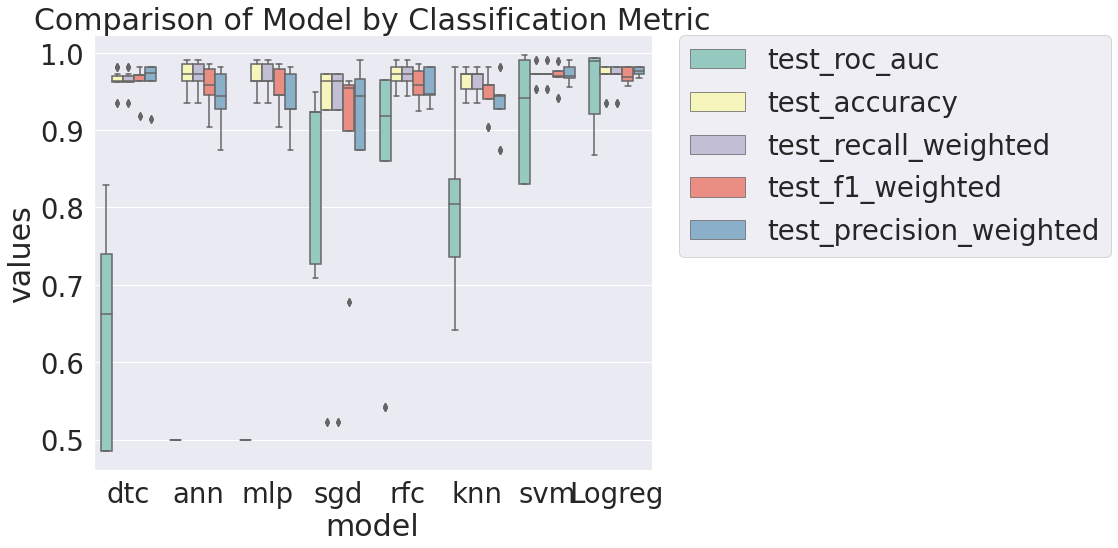

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

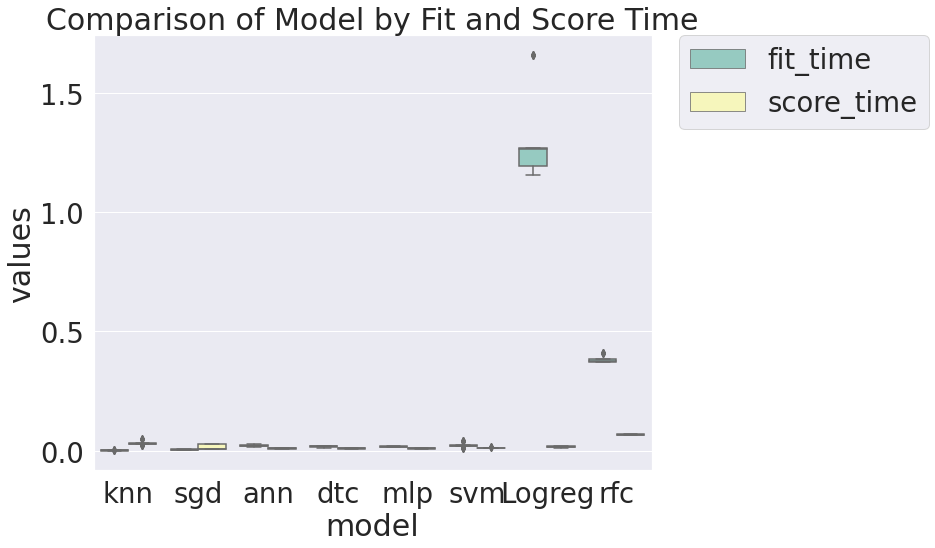

In [166]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [163]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_accuracy            ... test_f1_weighted          
                 std      mean  ...              std      mean
model                           ...                           
Logreg      0.016223  0.969009  ...         0.009031  0.970154
ann         0.018419  0.968461  ...         0.027281  0.953030
dtc         0.012064  0.964053  ...         0.017146  0.965116
knn         0.017151  0.961356  ...         0.026725  0.945842
mlp         0.020150  0.965383  ...         0.029837  0.948483
rfc         0.015161  0.970639  ...         0.021007  0.958017
sgd         0.133098  0.911535  ...         0.084252  0.912508
svm         0.011382  0.971492  ...         0.015821  0.969515

[8 rows x 10 columns]

In [164]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time           score_time          
             std      mean        std      mean
model                                          
Logreg  0.179910  1.315397   0.002939  0.016304
ann     0.004333  0.021105   0.001432  0.010046
dtc     0.003007  0.017721   0.000948  0.009589
knn     0.000462  0.001319   0.007780  0.031639
mlp     0.001169  0.018157   0.000881  0.010060
rfc     0.014555  0.383102   0.001364  0.067624
sgd     0.002537  0.005706   0.008379  0.014344
svm     0.008924  0.023158   0.001463  0.011356